In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import numpy as np
import pandas as pd
import os
import glob
import datatool.seddata
import general.utils
import result_analyse.kfold_analyse as an
import metric.Metrics
import result_analyse.visualisation as vs
from SED.evaluation_measures import psds_score, compute_psds_from_operating_points, compute_metrics
import SED.evaluation_measures 
import psds_eval

rootFolder='/workspace/sed2020/'   
    
@interact
def result_selector(gtf=os.listdir(f'{rootFolder}/metadata/')):
    typ=gtf.split('.')[0]
    gtf=f'{rootFolder}/metadata/{gtf}'
    groundtruth=pd.read_csv(gtf,delimiter='\t')
    groundtruth_dataset=datatool.seddata.SED(gtf,typ,None)
    
    groundtruth_dataset.load()
    meta_dur_df=pd.DataFrame(columns=['filename','duration'])
    meta_dur_df['filename']=groundtruth['filename']
    meta_dur_df['duration']=10
    @interact
    def result_selector(team=sorted(os.listdir(f'{rootFolder}/submissions/'))):
        @interact
        def result_selector(code=sorted([x for x in os.listdir(f'{rootFolder}/submissions/{team}') if os.path.isfile(f'{rootFolder}/submissions/{team}/{x}/{typ}/{x}.output.tsv')]) ):
            title=code.replace('_task4','')
            base_prediction_path=f'{rootFolder}/submissions/{team}/{code}/{typ}/'
            pef = f'{base_prediction_path}/{code}.output.tsv'
            psdsf = f'{base_prediction_path}/{code}.output_PSDS'            
            print(gtf,pef,psdsf)
#             get_single_result(pef,groundtruth,meta_dur_df,psdsf, groundtruth_dataset)
            return
            computeGem(pef, groundtruth_dataset)
            
            
            # Evaluate a single prediction
            single_predictions = pd.read_csv(pef, sep="\t")
            compute_metrics(single_predictions, groundtruth,meta_dur_df)
            
            

            # Evaluate predictions with multiple thresholds (better). Need a list of predictions.
            prediction_list_path = glob.glob(os.path.join(psdsf, "*.tsv"))
            list_predictions = []
            for fname in prediction_list_path:
                pred_df = pd.read_csv(fname, sep="\t")
                list_predictions.append(pred_df)
            psds = compute_psds_from_operating_points(list_predictions, groundtruth, meta_dur_df)
            psds_score(psds, filename_roc_curves=os.path.join(base_prediction_path, "figures/psds_roc.png"))

    
    



In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import numpy as np
import pandas as pd
import os
import glob
import datatool.seddata
import general.utils
import result_analyse.kfold_analyse as an
import metric.Metrics
import result_analyse.visualisation as vs
from SED.evaluation_measures import psds_score, compute_psds_from_operating_points, compute_metrics
import SED.evaluation_measures 
import psds_eval
rootFolder='/workspace/sed2020/'


# res1=get_single_result('/workspace/sed2020//metadata/public.tsv','/workspace/sed2020//submissions/CTK_NU/CTK_NU_task4_SED_1/public//CTK_NU_task4_SED_1.output.tsv','/workspace/sed2020//submissions/CTK_NU/CTK_NU_task4_SED_1/public//CTK_NU_task4_SED_1.output_PSDS')
# res2=get_single_result('/workspace/sed2020//metadata/public.tsv','/workspace/sed2020//submissions/CTK_NU/CTK_NU_task4_SED_3/public//CTK_NU_task4_SED_3.output.tsv','/workspace/sed2020//submissions/CTK_NU/CTK_NU_task4_SED_1/public//CTK_NU_task4_SED_3.output_PSDS')

# total=pd.DataFrame({'res1':{c:res1[c].loc['macro-avg']['f1'] for c in res1.keys()},
#                    'res2':{c:res2[c].loc['macro-avg']['f1'] for c in res2.keys()} }).T

# print(total)

# Run All submissions

In [ ]:

import numpy as np
import pandas as pd
import os
#@interact
#def result_selector(gtf=os.listdir(f'{rootFolder}/metadata/')):
import SED.my_eval
gtf='public.tsv'
rootFolder='/workspace/sed2020/'
typ=gtf.split('.')[0]
gtf=f'{rootFolder}/metadata/{gtf}'
# meta_dur_df=pd.DataFrame(columns=['filename','duration'])
# meta_dur_df['filename']=groundtruth['filename']
# meta_dur_df['duration']=10

l=['Miyazaki_NU_task4_SED_1','Miyazaki_NU_task4_SED_3','Hao_CQU_task4_SED_4','Koh_NTHU_task4_SED_3','Liu_thinkit_task4_SED_3','Miyazaki_NU_task4_SED_2','Ebbers_UPB_task4_SED_1','Hao_CQU_task4_SED_2','CTK_NU_task4_SED_4','Yao_UESTC_task4_SED_3']
# l=['Ebbers_UPB_task4_SED_1']
total_dic={}
for team in sorted(os.listdir(f'{rootFolder}/submissions/')):
    print(f'analysing team {team}')
    for code in sorted(os.listdir(f'{rootFolder}/submissions/{team}')):
        if not(code in l):continue
        print(f'    {code}')
        
        base_prediction_path=f'{rootFolder}/submissions/{team}/{code}/{typ}/'
        pef = f'{base_prediction_path}/{code}.output.tsv'
        if not(os.path.isfile(pef)):
            all=[x for x in os.listdir(base_prediction_path) if '.output.tsv' in x]
            if len(all)>0:
                pef=f'{base_prediction_path}/{all[0]}'
            else:
                print(pef)
                continue
        title=code.replace('_task4','')
        try:
            res1=SED.my_eval.get_single_result(gtf,pef,debug=0)
            total_dic[title]=res1
#             print(res1['detection'])
#             break
        except Exception as e:
            print('Error! submission is ignored',e)
#         if('gem' in res1):
#             for k in res1['gem'].keys():
#                 total_dic[title][f'gem-{k}']=res1['gem'].loc['avg'][k]
#     break

fs={s:{c:total_dic[s][c].loc['macro-avg']['f1'] for c in total_dic[s]} for s in total_dic  }
total=pd.DataFrame(fs).T
total

# Chart compare all

In [ ]:
def aliplot(total):
    from matplotlib.pylab import plt
    w={'detection':1.,
       'uniformity':1.,
       'total duration':1.,
       'relative duration':1.,
#        'boundary onset':1.
      }
    wsum=sum(w.values())
    for wi in w:
        if('our' in total): total['our']+=w[wi]/wsum*total[wi]
        else: total['our']=w[wi]/wsum*total[wi]
#     total['tmp']=total['total duration']/total['detection']
#     print(total[['tmp','relative duration']])
#     print(total['gem'])
    total=total.sort_values(['collar'])
#     total=total[-10:]
#     total=total[7:]
    fig, axs = plt.subplots(1, 2, figsize=(8, len(total)/3), sharey=True)
#     total=total.sort_values(['gem'])
    import pandas
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    # colorcycle = cycler(color=['blue', 'orange', 'green', 'magenta'])
    # Or use the default color cycle:
    # colorcycle = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])



    ind = np.arange(len(total))
    def myplot(ax,colis):
        cols=total.columns[colis]
        width = .9/len(cols)
        marker = itertools.cycle(( '^', 'o', 'D', 's','X', '*'))
        i=0
        ax.grid(True)
        # fig, ax = plt.subplots(figsize=(5,10))
        for i,x in enumerate(cols):
            if x=='y':continue
#             ax.plot(total[x],ind+.2 ,label=x,marker=next(marker),alpha=.75)
            ax.scatter(total[x],ind+.2 ,label=x,marker=next(marker),alpha=.75)
    #         ax.barh(ind+.4-i*width, total[x], width, label=x)#, color='red'

        ax.set(yticks=ind + width, yticklabels=[f'S{len(total)-i} : {y.replace("_SED","")}' for i,y in enumerate(total.index)], ylim=[-.5, len(total)-.5])
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
                  fancybox=True, shadow=True, ncol=2)
        ax.set_xlabel('F1')

#     myplot(axs[0],np.append([0,1,len(total.columns)-1],range(2,len(total.columns)-5)))
    myplot(axs[0],[0,1,len(total.columns)-1,2,4,5])
    # myplot(axs[1],[2])
#     myplot(axs[1],range(len(total.columns)-9,len(total.columns)-1))
#     myplot(axs[1],[8,11,12,13])
    myplot(axs[1],[8,11,12,13,14])
    
    # print(total)
# 
    fig.tight_layout()

    plt.show()

fs={s:{c:total_dic[s][c].loc['macro-avg']['f1'] for c in total_dic[s]} for s in total_dic  }
total=pd.DataFrame(fs).T
total
aliplot(total)
# total.sort_values(['events'],ascending=False)[:10]

In [ ]:

fs={s:{c:total_dic[s][c].loc['macro-avg']['f1'] for c in total_dic[s]} for s in total_dic  }
total=pd.DataFrame(fs).T
total
# print([c for s in total_dic for c in total_dic[s]])

In [ ]:
print('a')
# s='Miyazaki_NU_SED_1'
s='CTK_NU_SED_1'
# print( total_dic[s]['collar'])
# print(total_dic[s]['collar'][['Ntp']])
team={c:total_dic[s][c] for c in total_dic[s] }
# print(team)
# aliplot2(team)
team['detection']
team['detection'].T/team['detection'].sum(axis=1)
(team['segment'].T/team['segment'].sum(axis=1)).T.sort_index()[['Ntp','Ntn','Nfp','Nfn']]
team['segment'].sort_index()[['Ntp','Ntn','Nfp','Nfn']]
# pd.concat(team, axis=1)
# print(pd.DataFrame(team).T.round(2))

In [ ]:
(team['total duration'].T/team['total duration'].sum(axis=1)).T.sort_index()[['Ntp','Ntn','Nfp','Nfn']]
team['total duration'].sort_index()[['Ntp','Ntn','Nfp','Nfn']]

In [ ]:
def aliplot2(team):
    from matplotlib.pylab import plt
    
    allmetrics=list(team.keys())
    metrics=[allmetrics[m] for m in [0,6,1,2,4,8,9,10,11,12,13,14]]
#     total=total[-10:]
    fig, axs = plt.subplots(1, len(metrics), figsize=(12, len(team[metrics[0]])/5), sharey=True)
#     total=total.sort_values(['gem'])
    import pandas
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    # colorcycle = cycler(color=['blue', 'orange', 'green', 'magenta'])
    # Or use the default color cycle:
    # colorcycle = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    removerows=['micro-avg','macro-avg']#,'Alarm_bell_ringing','Blender']


    ind = np.arange(len(team['total duration'].drop(removerows)))
    def myplot(ax,num,m):
#         print(team[m])
        
        team_m=team[m][['Ntp','Nfn','Nfp']].drop(removerows,errors='ignore')
        team_m=team_m.sort_index()
        ind = np.arange(len(team_m))
        cols=team_m
        team_m=(team_m.T/team_m.sum(axis=1)).T
        width = .8
        marker = itertools.cycle(( '^', 'o', 'D', 's','X', '*'))
        i=0
#         ax.grid(True)
        
        # fig, ax = plt.subplots(figsize=(5,10))
#         for i,x in enumerate(cols):
#             if x=='y':continue
#             print(team[m][x])
#             ax.plot(team[m][x].T,ind+.2 ,label=x,marker=next(marker),alpha=.75)
#             ax.scatter(total[x],ind+.2 ,label=x,marker=next(marker),alpha=.75)
#             ax.barh(ind+.4-i*width, team[m][x], width, label=x)#, color='red'
            
        ax.barh(ind+.8, team_m['Ntp'], width, label='TP',color='g')#, color='red'
        ax.barh(ind+.8, team_m['Nfn'], width,left=team_m['Ntp'], label='FN',color='#f6ff00',alpha=.25)#, color='red'
        ax.barh(ind+.8, team_m['Nfp'], width,left=team_m[['Ntp','Nfn']].sum(axis=1), label='FP',color='r',alpha=1)#, color='red'
        

        ax.set(yticks=ind + width, yticklabels=[f'C{len(team_m)-i} : {y}' for i,y in enumerate(team_m.index)], ylim=[0.4, len(team_m)+.2],xlim=[0,1])
        if num==4:
            ax.legend(loc='upper center', bbox_to_anchor=(0, -0.35),fancybox=True, shadow=True, ncol=5)
        ax.set_xlabel(m.replace(' ','\n'))

#     myplot(axs[0],np.append([0,1,len(total.columns)-1],range(2,len(total.columns)-5)))
#     myplot(axs[0],[0,1,len(total.columns)-1,2,4,6])
    # myplot(axs[1],[2])
    ddd=pd.DataFrame(columns=['duration','events'])
    gdurations=team['total duration'][['Ntp','Nfn']].drop(removerows).sum(axis=1).sort_index()
    ddd['duration']=gdurations
    print(gdurations)
    gdp=gdurations/gdurations.sum()
    pdurations=team['total duration'][['Ntp','Nfp']].drop(removerows).sum(axis=1).sort_index()
    gevents=team['detection2'][['Ntp','Nfn']].drop(removerows).sum(axis=1).sort_index()
    gep=gevents/gevents.sum()
    ddd['events']=gevents
    pevents=team['detection2'][['Ntp','Nfp']].drop(removerows).sum(axis=1).sort_index()
#     ddd=ddd.astype(float)
    ddd=ddd.applymap('{:,.0f}'.format)
#     print(ddd)
#     a=a.round()
#     axs[0].barh(ind+1.1, gdp, .2, label='reference duration',color='g',alpha=.8)#, color='red'
#     axs[0].barh(ind+.9, pdurations/pdurations.sum(), .2, color='b', label='prediction duration',alpha=1)#, color='red'
#     axs[0].barh(ind+.7, gep, .2, label='reference count',color='y',alpha=.7)#, color='red'
#     axs[0].barh(ind+.5, pevents/pevents.sum(), .2, label='prediction count',color='c',alpha=1)#, color='red'
#     axs[0].legend(loc='upper center', bbox_to_anchor=(2, -0.25),fancybox=True, shadow=True, ncol=5)
#     axs[0].set_xscale('log')
#     the_table = axs[-1].table(
#         cellText=ddd.values,
#         loc='center',
# #         colLabels=ddd.columns,
#     )
#     the_table.auto_set_font_size(False)
#     the_table.set_fontsize(7)
    

    for i,m in enumerate(metrics):
        myplot(axs[i],i,m)
#     myplot(axs[1],range(len(total.columns)-8,len(total.columns)-1))
    
    # print(total)
    plt.show()

aliplot2(team)
# total.sort_values(['events'],ascending=False)[:10]

# New Chart

In [ ]:
def aliplot3(team):
    from matplotlib.pylab import plt
    
    allmetrics=list(team.keys())
    removerows=['micro-avg','macro-avg']#,'Alarm_bell_ringing','Blender']
    metrics=allmetrics
#     total=total[-10:]
    fig, axs = plt.subplots(1, len(metrics), figsize=(len(metrics), len(team[metrics[0]])/5), sharey=True)
#     total=total.sort_values(['gem'])
    import pandas
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    # colorcycle = cycler(color=['blue', 'orange', 'green', 'magenta'])
    # Or use the default color cycle:
    # colorcycle = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    

    gtf='/workspace/sed2020/metadata/public.tsv'
    gt = pd.read_csv(gtf, sep="\t")

    gt['duration']=gt.offset-gt.onset
    print(gt['duration'].mean())
    info=gt.groupby('event_label')['duration'].agg(['mean','std','count'])
    info=info.loc[metrics]
    print(info)
    maxd=(info['mean']+info['std']).max().max();
    print(maxd)
    gt['duration']=maxd
    info_n=info/maxd

    avg_e_dur=pd.Series({m:team[m].loc['total duration'][['Ntp','Nfn']].sum()/team[m].loc['detection'][['Ntp','Nfn']].sum() for m in metrics})
    avg_e_dur=pd.Series({m:team[m].loc['total duration'][['Ntp','Nfn']].sum()/team[m].loc['detection'][['Ntp','Nfn']].sum() for m in metrics})
    e_count=pd.Series({m:team[m].loc['detection'][['Ntp','Nfn']].sum() for m in metrics})
    
#   
    avg_e_dur=avg_e_dur/avg_e_dur.max()
    print(e_count.max())
    e_count=e_count/e_count.max()
    
    ind = np.arange(len(team[list(team.keys())[0]]))
    def myplot(ax,num,m):
#         print(team[m])
        
        team_m=team[m][['Ntp','Nfn','Nfp']]#.iloc[[0,6,8,2,1,12,10,11,9,13,14,15]]
        
#         team_m=team_m.sort_index()
        ind = np.arange(len(team_m))
        cols=team_m
        team_m=(team_m.T/team_m.sum(axis=1)).T
        width = .8
        marker = itertools.cycle(( '^', 'o', 'D', 's','X', '*'))
        i=0

        ax.barh(ind+.8, team_m['Ntp'], width, label='TP',color='g')#, color='red'
        ax.barh(ind+.8, team_m['Nfn'], width,left=team_m['Ntp'], label='FN',color='#f6ff00',alpha=.25)#, color='red'
        ax.barh(ind+.8, team_m['Nfp'], width,left=team_m[['Ntp','Nfn']].sum(axis=1), label='FP',color='r',alpha=1)#, color='red'
        
        
        ax.barh(-.2,e_count[m],width,label='Count')
#         ax.barh(-1,avg_e_dur[m],width,label='Duration(avg)')
        ax.barh(-1,info_n.loc[m]['mean'],width,label='Duration (std)')
        ax.errorbar( info_n.loc[m]['mean'],-1.1, xerr=info_n.loc[m]['std'],color='black',elinewidth=1, fmt='-.')
        all_data=gt['duration'][gt['event_label']==m]
        
        ax.set(yticks=ind + width, yticklabels=[f'{y}' for i,y in enumerate(team_m.index)], ylim=[0.4-2, len(team_m)+.2],xlim=[0,1])
        if num==2:
            ax.legend(loc='upper center', bbox_to_anchor=(0, -0.45),fancybox=True, shadow=True, ncol=5)
        ax.set_xlabel(m.replace(' ','\n').replace('bell_','').replace('_','\n'))
        

#         ax.set_xticks(np.arange(0, 1, .5))
        ax.set_xticks(np.arange(0, 1, .25), minor=True)

        ax.grid(True,axis='x',which='both')

    for i,m in enumerate(metrics):
        myplot(axs[i],i,m)
#     myplot(axs[1],range(len(total.columns)-8,len(total.columns)-1))
    
    # print(total)
    plt.show()

for s in ['Miyazaki_NU_SED_1','CTK_NU_SED_4','Hao_CQU_SED_4']:#total_dic:
    print(s)
    metrics=[m for m in total_dic[s]]
    metrics=['collar','psd d/gtc=0.8','psd d/gtc=0.5','psd d/gtc=0.1','detection','segment','total duration','uniformity','relative duration']
    team={m:total_dic[s][m] for m in metrics }

#     metrics=list(team.keys())
    clas=[c for c in team[metrics[0]].index[:-2]]
#     clas=[c for i,c in enumerate(clas) if i in [0,2,3,4,9]]
    clas=['Dishes',  'Cat', 'Speech', 'Blender','Alarm_bell_ringing']
    print(clas)
    team3={c:pd.DataFrame({m: team[m].loc[c] for m in metrics}).T for c in clas}
#     print(team3)
    aliplot3(team3)
# total.sort_values(['events'],ascending=False)[:10]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)
# example error bar values that vary with x-position
error = 0.1 + 0.2 * x
# error bar values w/ different -/+ errors
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x[0],-1, xerr=error[0], fmt='-o')
ax0.set_title('variable, symmetric error')

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()

In [ ]:
m='Blender'
# print(team)
# pd.DataFrame({m:team3[m].loc['total duration'][['Ntp','Nfn']].sum()})
a={m:team3[m].loc['total duration'][['Ntp','Nfn']].sum()  for m in team3}
a=pd.Series(a)/pd.Series(a).max()

In [ ]:
pd.Series(a)/a.drop(['macro-avg','micro-avg']).max()

# Test Maker


In [4]:
def Convert2SED(g,p,duration,path=None):
    
    gdf=pd.DataFrame(g,columns=['onset','offset'])
#     gdf=gdf/5
    gdf['event_label']='Test'
    gdf['filename']='Test'
    gdf=gdf[['filename','onset','offset','event_label']]

    pdf=pd.DataFrame(p,columns=['onset','offset'])
#     pdf=pdf/6
    pdf['event_label']='Test'
    pdf['filename']='Test'
    pdf=pdf[['filename','onset','offset','event_label']]
    
    meta_df=pd.DataFrame(columns=['filename','duration'])
    meta_df['filename']=gdf['filename'].unique()
#     meta_df['duration']=max(gdf['offset'].max(),pdf['offset'].max())
    meta_df['duration']=duration
    if path != None:
        import os
        from pathlib import Path
        Path(path).mkdir(parents=True, exist_ok=True)
        meta_df.to_csv(f'{path}/meta.tsv',sep='\t',index=False)
        pdf.to_csv(f'{path}/p.tsv',sep='\t',index=False)
        gdf.to_csv(f'{path}/g.tsv',sep='\t',index=False)
    return gdf,pdf,meta_df

In [ ]:
r[11:,:]+1


## all possible situation

============== class=Test=========file=Test
real= [[28.  30.5]
 [31.  31.5]
 [32.  33.5]]
pred= [[27.5 28.5]
 [29.  29.5]
 [30.  32.5]
 [33.  34. ]]
real_= [(0, 28.0), (30.5, 31.0), (31.5, 32.0), (33.5, 34.5)]
pred_= [(0, 27.5), (28.5, 29.0), (29.5, 30.0), (32.5, 33.0), (34.0, 34.5)]
r+: {0: {'p+': {0: [28.0, 28.5], 1: [29.0, 29.5], 2: [30.0, 30.5]}, 'p-': {1: [28.5, 29.0], 2: [29.5, 30.0]}}, 1: {'p+': {2: [31.0, 31.5]}, 'p-': {}}, 2: {'p+': {2: [32.0, 32.5], 3: [33.0, 33.5]}, 'p-': {3: [32.5, 33.0]}}, 3: {'p+': {}, 'p-': {}}}
r-: {0: {'p+': {0: [27.5, 28.0]}, 'p-': {0: [0, 27.5]}}, 1: {'p+': {2: [30.5, 31.0]}, 'p-': {}}, 2: {'p+': {2: [31.5, 32.0]}, 'p-': {}}, 3: {'p+': {3: [33.5, 34.0]}, 'p-': {4: [34.0, 34.5]}}}
p+: {0: {'r+': {0: [28.0, 28.5]}, 'r-': {0: [27.5, 28.0]}}, 1: {'r+': {0: [29.0, 29.5]}, 'r-': {}}, 2: {'r+': {0: [30.0, 30.5], 1: [31.0, 31.5], 2: [32.0, 32.5]}, 'r-': {1: [30.5, 31.0], 2: [31.5, 32.0]}}, 3: {'r+': {2: [33.0, 33.5]}, 'r-': {3: [33.5, 34.0]}}, 4: {'r+': {}, 

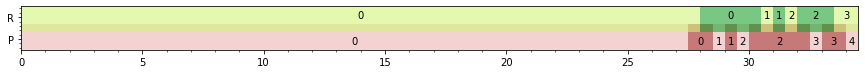

detection {'tp': 3, 'fp': 0, 'fn': 0, 'tn': 2}
detect-mono {'tp': 3, 'fp': 2, 'fn': 3, 'tn': 2}
monotony {'tp': 0, 'fp': 4, 'fn': 3, 'tn': 2}
uniformity {'tp': 1.0, 'fp': 2.5833333333333335, 'fn': 2.0, 'tn': 0}
total duration {'tp': 3.0, 'fp': 2.0, 'fn': 1.5, 'tn': 28.0}
relative duration {'tp': 2.2666666666666666, 'fp': 0.5178571428571429, 'fn': 0.7333333333333334, 'tn': 1.4821428571428572}
boundary onset {'tp': 0.8, 'fp': 2.2, 'fn': 0.0, 'tn': 0}
boundary offset {'tp': 0.8666666666666667, 'fp': 2.1333333333333333, 'fn': 0.0, 'tn': 0}


,Ntp,Nfn,Nfp
collar,0.0,3.0,4.0
segment,6.0,0.0,1.0
psd d/gtc=0.1,3.0,0.0,0.0
psd d/gtc=0.3,3.0,0.0,0.0
psd d/gtc=0.5,3.0,0.0,0.0
psd d/gtc=0.8,0.0,0.0,3.0
psd d/gtc=0.85,0.0,0.0,3.0
psd d/gtc=0.9,0.0,0.0,3.0
detection,3.0,0.0,0.0
detect-mono,3.0,3.0,2.0


In [7]:
import pandas as pd
import SED.my_eval
scale=2
r=np.array([[2,3],[5,6],[9,10],[11,13],[14,17],[18,20],[22,24],[25,27],[30,31],[33,34],[37,38],[40., 45.],[47., 49.],[50., 51.],[52., 54.],[56., 61.],[62., 63.],[64., 67.]])/scale
p=np.array([[1,2],[3,4],[7,8],[9,10],[11,12],[15,16],[19,20],[21,23],[26,28],[29,32],[33,35],[36,38],[39., 41.], [42., 43.], [44., 46.], [48., 53.], [55., 57.], [58., 59.], [60., 65.], [66., 68.]])/scale
r=np.array([[56., 61.],[62., 63.],[64., 67.]])/scale
p=np.array([[55., 57.], [58., 59.], [60., 65.], [66., 68.]])/scale


rdf,pdf,meta=Convert2SED(r,p,duration=69/scale)
    

res=SED.my_eval.get_single_result_df(rdf,pdf,meta,debug=1)
res={m:res[m].loc['Test'][['Ntp','Nfn','Nfp']] for m in res}
pd.DataFrame(res).T.round(1)

In [2]:
!pip install sox


In [ ]:
parts={ '1':{'r':range(0,11),'p':range(0,12)},
        '2':{'r':range(11,12),'p':range(12,15)},
        '3':{'r':range(12,15),'p':range(15,16)},
        '4':{'r':range(15,18),'p':range(16,20)}  }
all={}
for part in parts:
    r2=r[parts[part]['r'],:]
    p2=p[parts[part]['p'],:]
    mi=min(r2.min(),p2.min())-1
    r2=r2-mi
    p2=p2-mi
    ma=max(r2.max(),p2.max())+1
    rdf,pdf,meta=Convert2SED(r2,p2,duration=ma)

#     print()
    import SED.my_eval2
    res=SED.my_eval.get_single_result_df(rdf,pdf,meta,debug=0)
    res={m:res[m].loc['Test'][['Ntp','Nfn','Nfp']] for m in res}
    all[f'Part {part}']=pd.DataFrame(res)

# print(pd.DataFrame(res).T.round(1))

# print(pd.concat(all).T.round(1))
pd.concat(all).T.round(1)

In [ ]:
pd.concat(all).T.round(1)

## Single test

In [ ]:
import pandas as pd
import SED.my_eval
path="/tmp/test/"

g=[[2,3],[5,6]]
p=[[1,2],[3,7]]
saveTestSED(path,g,p,10)
res=SED.my_eval.get_single_result(f'{path}/g.tsv',f'{path}/p.tsv',f'{path}/meta.tsv',debug=0)
# for m in res:
for m in ['segment','total duration']:
    print(m)
    print(pd.DataFrame(res[m][['Ntp','Nfp','Nfn','Ntn']]))
    print('')

In [ ]:
pd.DataFrame([[2,3],[5,6]],columns=['onset','offset'])
# g=[[2,3],[5,6]]
# p=[[1,2],[3,7]]

In [ ]:

gtf='/workspace/sed2020/metadata/public.tsv'
gt = pd.read_csv(gtf, sep="\t")
gt

## real test

In [ ]:
import pandas as pd
import SED.my_eval
path="/tmp/test/"

gtf='/workspace/sed2020/metadata/public.tsv'
pef='/workspace/sed2020/submissions/CTK_NU/CTK_NU_task4_SED_1/public/CTK_NU_task4_SED_1.output.tsv'

gt = pd.read_csv(gtf, sep="\t")
    # Evaluate a single prediction
pt = pd.read_csv(pef, sep="\t")

clas=gt.event_label.append(pt.event_label).unique()
    
result={}
for c in ['Blender']:
        gtc=gt.loc[gt.event_label==c]
        ptc=pt.loc[pt.event_label==c]
        all=None
        for f in gtc.filename.unique():
            # if(c=='Blender'):debug=1
#             print(f'============== class={c}=========file={f}')
            g=gtc.loc[gtc.filename==f][['onset','offset']].values
            p=ptc.loc[ptc.filename==f][['onset','offset']].values
            saveTestSED(path,g,p,10)
            res=SED.my_eval.get_single_result(f'{path}/g.tsv',f'{path}/p.tsv',f'{path}/meta.tsv',debug=0)
            # for m in res:
            out={}
            out['segment']=res['segment'][['Ntp','Nfp','Nfn']].loc['Test']
            out['total duration']=res['total duration'][['Ntp','Nfp','Nfn']].loc['Test']
            out['diff']=out['segment']-out['total duration']
            out=pd.DataFrame(out).T
            if(all is None):
                all=out
            else:
                all+=out
            if (out.loc['diff']['Nfp'])>.1:
                print(f'============== class={c}=========file={f}')
                print(out)
#             res=SED.my_eval.get_single_result(f'{path}/g.tsv',f'{path}/p.tsv',f'{path}/meta.tsv',debug=1)
#             break
#         break

all


# Single file result direct

In [ ]:
print('ali')
import pandas as pd
import SED.my_eval
path="/tmp/test/"

gtf='/workspace/sed2020/metadata/public.tsv'
pef='/workspace/sed2020/submissions/CTK_NU/CTK_NU_task4_SED_1/public/CTK_NU_task4_SED_1.output.tsv'

gt = pd.read_csv(gtf, sep="\t")
    # Evaluate a single prediction
pt = pd.read_csv(pef, sep="\t")

clas=gt.event_label.append(pt.event_label).unique()
    
result={}
for f in gt.filename.unique():

        gtc=gt.loc[gt.filename==f]
        ptc=pt.loc[pt.filename==f]
        all=None
        res=SED.my_eval.get_single_result_df(gtc,ptc,debug=0)
        # for m in res:
        out={}
        out['segment']=res['segment'][['Ntp','Nfp','Nfn']].loc['Test']
        out['total duration']=res['total duration'][['Ntp','Nfp','Nfn']].loc['Test']
        out['diff']=out['segment']-out['total duration']
        out=pd.DataFrame(out).T
        if(all is None):
            all=out
        else:
            all+=out
        if (out.loc['diff']['Nfp'])>.1:
            print(f'============== class={c}=========file={f}')
            print(out)
#             res=SED.my_eval.get_single_result(f'{path}/g.tsv',f'{path}/p.tsv',f'{path}/meta.tsv',debug=1)
#             break
#         break

all


## single team test

In [ ]:
print('ali')
import pandas as pd
import SED.my_eval
gtf='/workspace/sed2020/metadata/public.tsv'
pef='/workspace/sed2020/submissions/CTK_NU/CTK_NU_task4_SED_1/public/CTK_NU_task4_SED_1.output.tsv'
res=SED.my_eval.get_single_result(gtf,pef,debug=0)
out={}
out['segment']=res['segment'][['Ntp','Nfp','Nfn']].loc['Blender']
out['total duration']=res['total duration'][['Ntp','Nfp','Nfn']].loc['Blender']
out['diff']=out['segment']-out['total duration']
pd.DataFrame(out).T

In [ ]:
res2={c:res[c].loc['Test'] for c in res.keys() }
print(pd.DataFrame(res2).T[ ['Nfn','Nfp','Ntp','precision','recall','f1' ]].round(2))

In [ ]:
# total=pd.DataFrame(total).T
# total['y']=total.index
# print(total)
# total2=total2[-20:-1]
# total2=total
import seaborn as sns
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(total2.sort_values("psds", ascending=False),
                 x_vars=total2.columns[0:-1], y_vars=['y'],
                 height=len(total2.index)/2, aspect=4/len(total2.index))

def qqplot(x, y, **kwargs):
#     sns.stripplot
    print(x.__dict__)
    sns.stripplot(x=x, y=y, data=total,**kwargs)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns anmidmx add better lab+(mx-mi)/2els
mx=total.max(axis=1).max()
mi=total.min(axis=1).min()
g.set(xlim=((mx+mi)/2,mx ), xlabel="F1", ylabel="")

# Use semantically meaningful titles for the columns
titles = total.columns[0:-1]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)


In [ ]:
a=[1,2,3,4]
a[-2:]

In [ ]:
# total=pd.DataFrame(total).T
# total['y']=total.index
# print(total)
import seaborn as sns
sns.set_theme(style="whitegrid")
# Make the PairGrid
g = sns.PairGrid(total.sort_values("gem-avg", ascending=False),
                 x_vars=total.columns[0:-1], y_vars=['y'],
                 height=len(total.index)/2, aspect=4/len(total.index))

f=lambda x,y: sns.barplot if(y==2) else sns.stripplot 
# Draw a dot plot using the stripplot function
g.map(f, size=15, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns anmidmx add better lab+(mx-mi)/2els
mx=total.max(axis=1).max()
mi=total.min(axis=1).min()
g.set(xlim=((mx+mi)/2,mx ), xlabel="F1", ylabel="")

# Use semantically meaningful titles for the columns
titles = total.columns[0:-1]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)  



In [ ]:

import numpy as np
import pandas as pd
import os
#@interact
#def result_selector(gtf=os.listdir(f'{rootFolder}/metadata/')):
# import SED.my_eval
gtf='public.tsv'
rootFolder='/workspace/sed2020/'
typ=gtf.split('.')[0]
gtf=f'{rootFolder}/metadata/{gtf}'
# meta_dur_df=pd.DataFrame(columns=['filename','duration'])
# meta_dur_df['filename']=groundtruth['filename']
# meta_dur_df['duration']=10
total_dic={}
for team in sorted(os.listdir(f'{rootFolder}/submissions/')):
    print(f'analysing team {team}')
    for code in sorted(os.listdir(f'{rootFolder}/submissions/{team}')):
        print(f'    {code}')
        base_prediction_path=f'{rootFolder}/submissions/{team}/{code}/{typ}/'
        pef = f'{base_prediction_path}/{code}.output.tsv'
        if not(os.path.isfile(pef)):
            all=[x for x in os.listdir(base_prediction_path) if '.output.tsv' in x]
            if len(all)>0:
                pef=f'{base_prediction_path}/{all[0]}'
            else:
                print(pef)
                continue
        title=code.replace('_task4','')
        groundtruth = pd.read_csv(gtf, sep="\t")
        # Evaluate a single prediction
        predictions = pd.read_csv(pef, sep="\t")
        res1=SED.my_eval.get_single_result(gtf,pef)


In [ ]:
#%matplotlib inline

clas=groundtruth.event_label.append(predictions.event_label).unique()
clas
gt=groundtruth
pt=predictions
import metric
# m=metric.GEM_NEW
for c in clas:
    gtc=gt.loc[gt.event_label==c]
    ptc=pt.loc[pt.event_label==c]
    
    for f in gtc.filename.unique():
        print(f'============== class={c}=========file={f}')
        g=gtc.loc[gtc.filename==f][['onset','offset']].values
        p=ptc.loc[ptc.filename==f][['onset','offset']].values
#         print(eval_my_metric(g,p,(0,10)))
        print(g)
        break
#         print('gtc',
#         print('ptc',ptc.loc[ptc.filename==f]).apply(p=>(p.onset,p.offset))
#         p=pt.loc[pt.event_label==c and pt.filename=g.filename]
#         print(p)
    break    


In [ ]:
# g2=np.array(g)
# g2=g2[g2[:,0].argsort(),:]
# g2[0,:]=g[-1]*2
# g2
np.vstack((g,[1,1]))

In [ ]:
def intersection(e1,e2):    
    inter=(max(e1[0],e2[0]),min(e1[1],e2[1]))
    if(inter[1]<=inter[0]): 
        inter=None
#     print(e1,e2,inter)
    return inter

def dur(e):
    d= e[1]-e[0]
    if(d<0):
        print('erorr duration is less than zero' )
    return d


def eval_my_metric(real,pred,duration=(0,10),alpha=2,debug=0,calcne=1):
        debug={'D':1,'T':1, 'M':1,'R':1,'V':1}#V:verbose
        # real=merge_events_if_necessary(real)
        # pred=merge_events_if_necessary(pred)
        # real_tree=_makeIntervalTree(real,'r')
        # pred_tree=_makeIntervalTree(pred,'p')
        duration=(min(duration[0],real[0][0]),max(duration[1],real[-1][1]))
        real=np.append(real,duration[1])# add a zero duration event in the end for ease comparision the last event
        real[-1]=(duration[1],duration[1])
        pred=np.append(pred,duration[1])# add a zero duration event in the end for ease comparision the last event
        pred[-1]=(duration[1],duration[1])
        #_ means negative
        rel={'r+':{},'r-':{},'p+':{},'p-':{}}
        print(real)
        r_0=(duration[0],real[0][0])
        r_n=(real[-1][1],duration[1])
        metric={}
        pi=0
        rcalc=[]
        real_=[]
        pred_=[]
        ri_=0
        for ri in range(len(real)):
            r=real[ri]
            rp=real[ri-1] if ri>0 else (duration[0],duration[0])
            r_=(rp[1],r[0])
            
            tmpr={'p+':{},'p-':{}}
            tmpr_={'p+':{},'p-':{}}
            rel['r+'][ri]=tmpr
            
            if(dur(r_)>0):
                real_.append(r_)
                ri_=len(real_)-1
                rel['r-'][ri_]=tmpr_
            
            cond=pi<len(pred) 
            pi_=-1
            while  cond:
                pp=pred[pi-1] if pi>0 else (duration[0],duration[0])
                p=pred[pi]
                p_=(pp[1],p[0])
                
                if(dur(p_)>0 and (len(pred_)==0 or pred_[-1]!=p_)):
                    pred_.append(p_)
                pi_=len(pred_)-1

                if not(pi in rel['p+']):
                    rel['p+'][pi]={'r+':{},'r-':{}}
                if not(pi_ in rel['p-']):
                    rel['p-'][pi_]={'r+':{},'r-':{}}
                tmpp=rel['p+'][pi]
                tmpp_=rel['p-'][pi_]

                rinter  =intersection(r,p)
                rinter_ =intersection(r,p_)
                r_inter =intersection(r_,p)                
                r_inter_=intersection(r_,p_)
                if(rinter is not None):
                    # tmpr['p+'].append((pi,rinter))
                    # tmpp['r+'].append((ri,rinter))
                    tmpr['p+'][pi]=rinter
                    tmpp['r+'][ri]=rinter
                if(rinter_ is not None):
                    # tmpr['p-'].append((pi,rinter_))
                    # tmpp_['r+'].append((ri,rinter_))
                    tmpr['p-'][pi_]=rinter_
                    tmpp_['r+'][ri]=rinter_
                if(r_inter is not None):
                    # tmpr_['p+'].append((pi,r_inter))
                    # tmpp['r-'].append((ri,r_inter))
                    tmpr_['p+'][pi]=r_inter
                    tmpp['r-'][ri_]=r_inter
                if(r_inter_ is not None):
                    # tmpr_['p-'].append((pi,r_inter_))
                    # tmpp_['r-'].append((ri,r_inter_))
                    tmpr_['p-'][pi_]=r_inter_
                    tmpp_['r-'][ri_]=r_inter_
                
                
                if pred[pi][1] < r[1]:
                    pi+=1
                else: cond=False
                
            
            # for k in list(rel.keys()):
            #     if len(rel[k])>0: continue
            #     del rel[k]
        
        real=np.delete(real,-1,0)#real.pop()
        pred=np.delete(pred,-1,0)#pred.pop()
#         if(dur(pred_[-1])==0):pred_=np.delete(pred_,-1,0)
#         if(dur(real_[-1])==0):real_=np.delete(real_,-1,0)

        
        out={
            'detection':        {'tp':0,'fp':0,'fn':0,'tn':0},
            'monotony':         {'tp':0,'fp':0,'fn':0,'tn':0},
            'total duration':   {'tp':0,'fp':0,'fn':0,'tn':0},
            'relative duration':{'tp':0,'fp':0,'fn':0,'tn':0}
        }
        
        if debug['V']:
            print("real=",real)
            print("pred=",pred)
            print("real_=",real_)
            print("pred_=",pred_)
            #for x in rel:
            [print(f'{x}: {rel[x]}') for x in rel]
        
        for ri in range(len(real)):
            tpd=int(len(rel['r+'][ri]['p+'])>0)
            out['detection']['tp']+=tpd
            if debug['D']: print(f"D TP+{tpd}      ri={ri}, p+={rel['r+'][ri]['p+']}>0")
            #monotony {
            if (len(rel['r+'][ri]['p+'])==1):
                for rpi in rel['r+'][ri]['p+']:
                    if len(rel['p+'][rpi]['r+'])==1:
                        out['monotony']['tp']+=1
                        if debug['M']:print(f"M TP+1     rel[r+][{ri}][p+]={rel['r+'][ri]['p+']}==1 rel[p+][{rpi}][r+]={rel['p+'][rpi]['r+']}==1")
                    elif(len(rel['p+'][rpi]['r+'])==0):
                        print('error it can not be zero')
                    elif debug['M']:print(f"M--tp rel[r+][{ri}][p+]={rel['r+'][ri]['p+']}==1 rel[p+][{rpi}][r+]={rel['p+'][rpi]['r+']}>1")
            #}
            
            for pi in rel['r+'][ri]['p+']:
                tpt=dur(rel['r+'][ri]['p+'][pi])
                tpr=tpt/dur(real[ri])
                out['total duration']['tp']+=tpt
                out['relative duration']['tp']+=tpr
                if debug['T']:print(f"T tp+={tpt}             rel[r+][{ri}][p+][{pi}]=dur({rel['r+'][ri]['p+'][pi]})")
                if debug['R']:print(f"R tp+={tpr}             rel[r+][{ri}][p+][{pi}]==dur({rel['r+'][ri]['p+'][pi]}) / real[{ri}]=dur({real[ri]})")
                          
            for pi in rel['r+'][ri]['p-']:
                fnt=dur(rel['r+'][ri]['p-'][pi])
                fnr=fnt/dur(real[ri])
                out['total duration']['fn']+=fnt
                out['relative duration']['fn']+=fnr
                if debug['T']:print(f"T fn+={fnt}             rel[r+][{ri}][p-][{pi}]=dur({rel['r+'][ri]['p-'][pi]})")
                if debug['R']:print(f"R fn+={fnr}             rel[r+][{ri}][p-][{pi}]==dur({rel['r+'][ri]['p-'][pi]}) / real[{ri}]=dur({real[ri]})")
                

        for ri in range(len(real_)):
            tnd=int(len(rel['r-'][ri]['p-'])>0)
            out['detection']['tn']+=tnd
            if debug['D']: print(f"D TN+{tnd}      ri-={ri}, p-={rel['r-'][ri]['p-']}>0")
            #monotony {
            
            if (len(rel['r-'][ri]['p-'])==1):
                for rpi in rel['r-'][ri]['p-']:
                    if len(rel['p-'][rpi]['r-'])==1:
                        out['monotony']['tn']+=1
                        if debug['M']:print(f"M TN+1     rel[r-][{ri}][p-]={rel['r-'][ri]['p-']}==1 rel[p-][{rpi}][r-]={rel['p-'][rpi]['r-']}==1")
                    elif(len(rel['p-'][rpi]['r-'])==0):
                        print('error it can not be zero')
                    elif debug['M']:print(f"M--tn rel[r-][{ri}][p-]={rel['r-'][ri]['p-']}==1 rel[p-][{rpi}][r-]={rel['p-'][rpi]['r-']}>1")
            #}

            for pi in rel['r-'][ri]['p-']:
                tnt=dur(rel['r-'][ri]['p-'][pi])
                tnr=tnt/dur(real_[ri])
                out['total duration']['tn']+=tnt
                out['relative duration']['tn']+=tnr
                if debug['T']:print(f"T tn+={tnt}             rel[r-][{ri}][p-][{pi}]=dur({rel['r-'][ri]['p-'][pi]})")
                if debug['R']:print(f"R tn+={tnr}             rel[r-][{ri}][p-][{pi}]==dur({rel['r-'][ri]['p-'][pi]}) / real_[{ri}]=dur({real_[ri]})")
            for pi in rel['r-'][ri]['p+']:
                fpt=dur(rel['r-'][ri]['p+'][pi])
                fpr=fpt/dur(real_[ri])
                out['total duration']['fp']+=fpt
                out['relative duration']['fp']+=fpr
                if debug['T']:print(f"T fp+={fpt}             rel[r-][{ri}][p+][{pi}]=dur({rel['r-'][ri]['p+'][pi]})")
                if debug['R']:print(f"R fp+={fpr}             rel[r-][{ri}][p+][{pi}]==dur({rel['r-'][ri]['p+'][pi]}) / real_[{ri}]=dur({real_[ri]})")

        out['detection']['fp']=len(real_)-out['detection']['tn']
        if debug['D']: print(f"D fp={out['detection']['fp']} #r-={len(real_)} - tn={out['detection']['tn']}"  )
        out['detection']['fn']=len(real)-out['detection']['tp']
        if debug['D']: print(f"D fn={out['detection']['fn']} #r+={len(real)} - tp={out['detection']['tp']}"  )
                        
        out['monotony']['fn']=len(real)-out['monotony']['tp']+len(pred_)-out['monotony']['tn']
        if debug['M']: print(f"M fn={out['monotony']['fn']}     #r+={len(real)} - tp={out['monotony']['tp']} + #p-={len(pred_)} - tn={out['monotony']['tn']}")
        out['monotony']['fp']=len(pred)-out['monotony']['tp']+len(real_)-out['monotony']['tn']
        if debug['M']: print(f"M fp={out['monotony']['fp']}     #p+={len(pred)} - tp={out['monotony']['tp']} + #r-={len(real_)} - tn={out['monotony']['tn']}")
        
                        
        for pi in range(len(pred)):
            fpd=int(len(rel['p+'][pi]['r+'])==0)
            out['detection']['fp']+=fpd
            if debug['D']: print(f"D FP+{fpd}      pi={pi}, r={rel['p+'][pi]['r+']}==0")
#             for ri in rel['p+'][pi]['r-']:
#                 out['total duration']['fp']+=dur(rel['p+'][pi]['r-'][ri])
#                 out['relative duration']['fp']+=dur(rel['p+'][pi]['r-'][ri])/dur(pred[pi])

        for pi in range(len(pred_)):
            fnd=int(len(rel['p-'][pi]['r-'])==0)
            out['detection']['fn']+=fnd
            if debug['D']: print(f"D FN+{fnd}      pi-={pi}, r-={rel['p-'][pi]['r-']}==0")
#             for ri in rel['p-'][pi]['r+']:
#                 out['total duration']['fn']+=dur(rel['p-'][pi]['r+'][ri])
#                 out['relative duration']['fn']+=dur(rel['p-'][pi]['r+'][ri])/dur(pred_[pi])

#         plot_events_with_event_scores(range(len(real)),range(len(pred)),real,pred)
#         plot_events_with_event_scores(range(len(real_)),range(len(pred_)),real_,pred_)
        if debug['V']:plot_events(real,pred,real_,pred_)
        return  out


In [ ]:
def plot_events(real,pred,real_,pred_, label=None):
    from matplotlib.pylab import plt
    import random
    fig,ax = plt.subplots(figsize=(10, 2))
    ax.set_title(label)
    plt.xlim(0,max(real[-1][1],10))
    ax.set_xticks(np.arange(0,max(real[-1][1],10),.1),minor=True)
    maxsize=20
    for i in range(min(maxsize,len(pred_))):
        d = pred_[i]
        plt.axvspan(d[0], d[1], 0, 0.4,linewidth=1,edgecolor='k',facecolor='m', alpha=.6)
        plt.text((d[1] + d[0]) / 2, 0.1+random.random()/4,f'{i}' , horizontalalignment='center', verticalalignment='center')
    for i in range(min(maxsize,len(pred))):
        d = pred[i]
        plt.axvspan(d[0], d[1], 0.1, 0.5,linewidth=1,edgecolor='k',facecolor='r', alpha=.6)
        plt.text((d[1] + d[0]) / 2, 0.2+random.random()/4,f'{i}' , horizontalalignment='center', verticalalignment='center')
#     maxsize=len(real)
    for i in range(min(maxsize,len(real_))):
        gt = real_[i]
        plt.axvspan(gt[0], gt[1], 0.6, 1,linewidth=1,edgecolor='k',facecolor='y', alpha=.6)
        plt.text((gt[1] + gt[0]) / 2, 0.6+random.random()/4,f'{i}' , horizontalalignment='center', verticalalignment='center')
        
    for i in range(min(maxsize,len(real))):
        gt = real[i]
        plt.axvspan(gt[0], gt[1], 0.5, .9,linewidth=1,edgecolor='k',facecolor='g', alpha=.6)
        plt.text((gt[1] + gt[0]) / 2, 0.5+random.random()/4,f'{i}' , horizontalalignment='center', verticalalignment='center')
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.show()